In [ ]:
# Mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import itertools

In [ ]:
# System setup

# Change working directory to project folder
os.chdir('/content/drive/MyDrive/Earth_System_Modelling/Earth-System-Modelling')

# Append project to path for easy imports
sys.path.append('/content/drive/MyDrive/Earth_System_Modelling/Earth-System-Modelling')

In [ ]:
# preprocess data
def prepro(raw_data):
    """ Preprocess data for SWBM
    Convert runoff, latent heat flux and solar net radiation to mm.
    Convert time to date.

    :param raw_data: raw input data (pandas df):
         -snr: surface net radiation
         -tp: total precipitation
         -ro: runoff
         -sm: soil moisture at the surface
         -le: latent heat flux
    :return: pre-processed data (pandas df)
    """

    data = {'time': pd.to_datetime(raw_data['time']),
            'lat': raw_data['latitude'],
            'long': raw_data['longitude'],
            'tp': raw_data['tp_[mm]'],
            'sm': raw_data['sm_[m3/m3]'] * 1000,
            'ro': raw_data['ro_[m]'] * 24000,
            'le': raw_data['le_[W/m2]'] * (86400 / 2260000),
            # 86400 (seconds) / 2260000 (latent heat of vaporization
            # of water in J/kg)
            'snr': raw_data['snr_[MJ/m2]'] * (1 / 2.26),
            'temp': raw_data['t2m_[K]']-243.8,
            }
    return pd.DataFrame(data)

In [ ]:
# Import the model
# The model is stored in another file
# all functions are definded there...
from swbm_mini import predict_ts, model_correlation

# Now you have access to the functions:
# prepro() predict_ts() model_correlation()

# Read the data
data_GER = pd.read_csv("data/Data_swbm_Germany_new.csv")
data_SWE = pd.read_csv("data/Data_swbm_Sweden_new.csv")
data_SPA = pd.read_csv("data/Data_swbm_Spain_new.csv")

# Prepare the data
data_prepro = prepro(data_GER)
data_prepro_SWE = prepro(data_SWE)
data_prepro_SPA = prepro(data_SPA)

# Include Temp Dependency in SWBM

- adding the process by multiplying the ET function with k*Temp**2


In [ ]:
# change the water balance model

def et2(b0, w_i, c_s, g, temp, kappa):
    """Compute proportion of maximum ET that occurs given current soil moisture."""
    return b0 * (w_i / c_s) ** g * (kappa*temp**2)

def runoff_fun(w_i, c_s, a):
    """Compute runoff fraction."""
    return (w_i / c_s) ** a

def predict(curr_moist, evapo, wrunoff, precip, rad):
    """Update soil moisture for next step."""
    return curr_moist + (precip - (evapo * rad) - (wrunoff * precip))

def predict_ts2(data, config, n_days=None):
    """Run the SMBW for given time series

    :param data: input data (pandas df) (time, tp, sm, ro, le, snr)
    :param config: parameters
                   - water holding capacity (c_s),
                   - maximum of ET function (b0),
                   - ET function shape (g),
                   - runoff function shape (a))
    :param n_days: time series length (default: None)
    :return: soil moisture, runoff, ET (for entire ts) (numpy arrays)
    """
    n_days = data.shape[0] if n_days is None else n_days

    # Initialize arrays for model outputs
    moists, runoffs, ets = np.zeros(n_days), np.zeros(n_days), np.zeros(n_days)

    # Initial soil moisture (90% of soil water holding capacity)
    moists[0] = 0.9 * config['c_s']

    # Parameters
    c_s = config['c_s']
    b0 = config['b0']
    g = config['g']
    a = config['a']
    kappa = config['kappa']

    for i in range(n_days):
        # Compute evapotrans. and runoff fractions
        ets[i] = et2(b0, moists[i], c_s, g, data['temp'][i], kappa)
        runoffs[i] = runoff_fun(moists[i], c_s, a)

        # Compute soil moisture for the next timestep
        if i < n_days - 1: # Avoid updating beyond the last index
            moists[i + 1] = predict(moists[i], ets[i], runoffs[i],
                                    data['tp'][i], data['snr'][i])

    # Convert runoff and ET fractions to actual fluxes
    runoffs = runoffs * np.asarray(data['tp'])
    ets = ets * np.asarray(data['snr'])
    return moists, runoffs, ets


## Preparing Dataset for Calibration

- creating one 2008-2013 dataset for training
- creating one 2014-2018 dataset for testing

In [ ]:
data_train_GER = data_prepro[(data_prepro['time'] >= '2008-01-01') &
                          (data_prepro['time'] <= '2013-12-31')].reset_index(drop=True)

data_test_GER = data_prepro[(data_prepro['time'] >= '2014-01-01') &
                          (data_prepro['time'] <= '2018-12-31')].reset_index(drop=True)

data_train_SWE = data_prepro_SWE[(data_prepro_SWE['time'] >= '2008-01-01') &
                          (data_prepro_SWE['time'] <= '2013-12-31')].reset_index(drop=True)

data_test_SWE = data_prepro_SWE[(data_prepro_SWE['time'] >= '2014-01-01') &
                          (data_prepro_SWE['time'] <= '2018-12-31')].reset_index(drop=True)

data_train_SPA = data_prepro_SPA[(data_prepro_SPA['time'] >= '2008-01-01') &
                          (data_prepro_SPA['time'] <= '2013-12-31')].reset_index(drop=True)

data_test_SPA = data_prepro_SPA[(data_prepro_SPA['time'] >= '2014-01-01') &
                          (data_prepro_SPA['time'] <= '2018-12-31')].reset_index(drop=True)

## Creating Calibration Function

- creating Parameter Matrix
- looping over all combinations
- for each combination run model function and correlation function
- return used parameter combination and the correlations
- additionally: test while looping if correlation increased or not

In [ ]:
def model_correlation(data, model_outputs, start=None, end=None):
    """
    Calculate correlation between observed data and model outputs,
    optionally restricted to a timeframe.

    :param data: pandas DataFrame with columns 'sm', 'ro', 'le' (observed)
    :param model_outputs: tuple of numpy arrays (moists, runoffs, ets)
    :param start: str or datetime, start date for analysis (optional)
    :param end: str or datetime, end date for analysis (optional)
    :return: dict with individual correlations and sum of correlations
    """
    moists, runoffs, ets = model_outputs

    # Apply timeframe selection if provided
    if start is not None or end is not None:
        mask = (data['time'] >= pd.to_datetime(start) if start else True) & \
               (data['time'] <= pd.to_datetime(end) if end else True)
        data = data.loc[mask]
        moists = moists[data.index]
        runoffs = runoffs[data.index]
        ets = ets[data.index]

    # Compute correlations
    corr_sm = np.corrcoef(data['sm'], moists)[0, 1]
    corr_ro = np.corrcoef(data['ro'], runoffs)[0, 1]
    corr_et = np.corrcoef(data['le'], ets)[0, 1]

    corr_sum = corr_sm + corr_ro + corr_et
    corr_mean = (corr_sm + corr_ro + corr_et) / 3

    return {'sm': corr_sm, 'ro': corr_ro, 'et': corr_et, 'sum': corr_sum, 'mean': corr_mean}


In [ ]:
# Parameter
params = {
    'c_s': [210, 420, 840],
    'a': [2, 4, 8],
    'g': [0.2, 0.5, 0.8],
    'b0': [0.4, 0.6, 0.8],
    'k': [0.0001, 0.0002, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005, 0.00055, 0.0006]
}


# Kombinationen als DataFrame
combinations = pd.DataFrame(
    list(itertools.product(*params.values())),
    columns=params.keys()
)

In [ ]:
# Funktion die beide Schritte ausführt
def evaluate_combination(row, data):
    # Config Dictionary für predict_ts2
    config = {
        'c_s': row['c_s'],
        'b0': row['b0'],
        'g': row['g'],
        'a': row['a'],
        'kappa': row['k']
    }

    # Erste Funktion: Modell laufen lassen
    model_outputs = predict_ts2(data, config)

    # Zweite Funktion: Korrelationen berechnen
    correlations = model_correlation(data, model_outputs)

    # Als Series zurückgeben
    return pd.Series({
        'corr_sm': correlations['sm'],
        'corr_ro': correlations['ro'],
        'corr_et': correlations['et'],
        'corr_sum': correlations['sum']
    })

## Also for old model

In [ ]:
# Parameter
params_old = {
    'c_s': [210, 420, 840],
    'a': [2, 4, 8],
    'g': [0.2, 0.5, 0.8],
    'b0': [0.4, 0.6, 0.8]
}


# Kombinationen als DataFrame
combinations_old = pd.DataFrame(
    list(itertools.product(*params_old.values())),
    columns=params_old.keys()
)

In [ ]:
# Funktion die beide Schritte ausführt
def evaluate_combination_old(row, data):
    # Config Dictionary für predict_ts2
    config = {
        'c_s': row['c_s'],
        'b0': row['b0'],
        'g': row['g'],
        'a': row['a']
    }

    # Erste Funktion: Modell laufen lassen
    model_outputs = predict_ts(data, config)

    # Zweite Funktion: Korrelationen berechnen
    correlations = model_correlation(data, model_outputs)

    # Als Series zurückgeben
    return pd.Series({
        'corr_sm': correlations['sm'],
        'corr_ro': correlations['ro'],
        'corr_et': correlations['et'],
        'corr_sum': correlations['sum']
    })

## Run calibrations for Sweden

In [ ]:
# Auf alle Kombinationen anwenden
results_SWE = combinations.apply(lambda row: evaluate_combination(row, data_train_SWE), axis=1)

# Kombiniere Parameter und Ergebnisse
final_df_SWE = pd.concat([combinations, results_SWE], axis=1)

# Optional: Nach Summe der Korrelationen sortieren
final_df_SWE = final_df_SWE.sort_values('corr_sum', ascending=False)

print(final_df_SWE.head())

     c_s  a    g   b0       k   corr_sm   corr_ro   corr_et  corr_sum  \
540  840  2  0.8  0.4  0.0001  0.092664  0.108872  0.886855  1.088391   
513  840  2  0.5  0.4  0.0001  0.092463  0.108906  0.886912  1.088282   
486  840  2  0.2  0.4  0.0001  0.092259  0.108941  0.886936  1.088136   
567  840  4  0.2  0.4  0.0001  0.060837  0.111581  0.886920  1.059338   
594  840  4  0.5  0.4  0.0001  0.060684  0.111540  0.886887  1.059112   

     corr_mean  
540   0.362797  
513   0.362761  
486   0.362712  
567   0.353113  
594   0.353037  


In [ ]:
# Define initial parameters
config = {
    'c_s': 420,    # soil water holding capacity in mm
    'a': 4,        # runoff function shape α
    'g': 0.5,      # ET function shape γ
    'b0': 0.8      # maximum of ET function β
}


In [ ]:
# Calibrated parameters
calibr_SWE = {
    'c_s': 840,    # soil water holding capacity in mm
    'a': 2,        # runoff function shape α
    'g': 0.8,      # ET function shape γ
    'b0': 0.4,      # maximum of ET function β
    'kappa': 0.0001  # new parameter
}

In [ ]:
moisture_SWE, runoff, et_flux = predict_ts(data_train_SWE, config) # old SWBM old config

In [ ]:
# Run the SWBM model
# moisture, runoff, et_flux = predict_ts(data_train, config)

In [ ]:
moisture2_SWE, runoff2_SWE, et_flux2_SWE = predict_ts2(data_train_SWE, calibr_SWE) # new SWBM calibrated config

In [ ]:
# Compute correlation over the whole timeseries
corrs = model_correlation(data_train_SWE, (moisture_SWE, runoff_SWE, et_flux_SWE))
print("Correlation between observed data and model outputs:\n")
print(f"Soil Moisture (sm):      {corrs['sm']:.3f}")
print(f"Runoff (ro):             {corrs['ro']:.3f}")
print(f"Evapotranspiration (et): {corrs['et']:.3f}")
print(f"\nSum of correlations:   {corrs['sum']:.3f}")

Correlation between observed data and model outputs:

Soil Moisture (sm):      -0.343
Runoff (ro):             0.036
Evapotranspiration (et): 0.858

Sum of correlations:   0.550


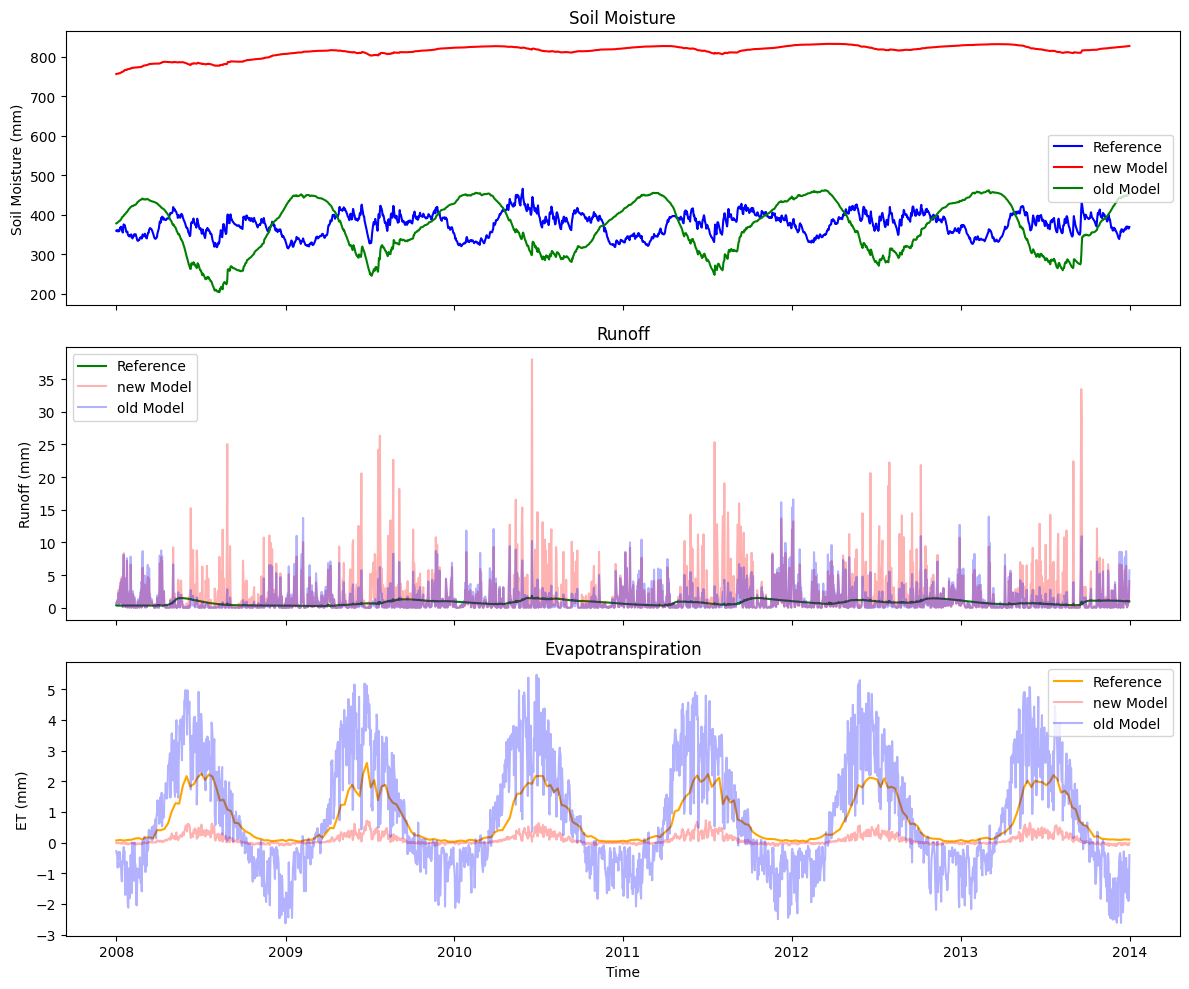

In [ ]:
# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Soil moisture
axes[0].plot(data_train_SWE['time'], data_train_SWE['sm'], color='blue', label  = 'Reference')
axes[0].set_ylabel('Soil Moisture (mm)')
axes[0].set_title('Soil Moisture')
axes[0].plot(data_train_SWE['time'], moisture2_SWE, color='red', label = 'new Model')
axes[0].plot(data_train_SWE['time'], moisture_SWE, color='green', label = 'old Model')
axes[0].legend()

# Runoff
axes[1].plot(data_train_SWE['time'], data_train_SWE['ro'], color='green', label = 'Reference')
axes[1].set_ylabel('Runoff (mm)')
axes[1].set_title('Runoff')
axes[1].plot(data_train_SWE['time'], runoff2_SWE, color='red', alpha = 0.3, label = 'new Model')
axes[1].plot(data_train_SWE['time'], runoff_SWE, color='blue', alpha = 0.3, label = 'old Model')
axes[1].legend()

# Evapotranspiration
axes[2].plot(data_train_SWE['time'], data_train_SWE['le'], color='orange', label = 'Reference')
axes[2].set_ylabel('ET (mm)')
axes[2].set_title('Evapotranspiration')
axes[2].plot(data_train_SWE['time'], et_flux2_SWE, color='red', alpha = 0.3, label = 'new Model')
axes[2].plot(data_train_SWE['time'], et_flux_SWE, color='blue', alpha = 0.3, label = 'old Model')
axes[2].set_xlabel('Time')
axes[2].legend()

plt.tight_layout()
plt.show()

## Calibrate old model

In [ ]:
# Auf alle Kombinationen anwenden
results_SWE_old = combinations_old.apply(lambda row: evaluate_combination_old(row, data_train_SWE), axis=1)

# Kombiniere Parameter und Ergebnisse
final_df_SWE_old = pd.concat([combinations_old, results_SWE_old], axis=1)

# Optional: Nach Summe der Korrelationen sortieren
final_df_SWE_old = final_df_SWE_old.sort_values('corr_sum', ascending=False)

print(final_df_SWE_old.head())

    c_s  a    g   b0   corr_sm   corr_ro   corr_et  corr_sum
19  210  8  0.2  0.6 -0.198226  0.058716  0.875084  0.735574
63  840  4  0.2  0.4 -0.266575  0.101249  0.878441  0.713114
54  840  2  0.2  0.4 -0.269220  0.099064  0.878163  0.708007
20  210  8  0.2  0.8 -0.198768  0.038125  0.865971  0.705329
66  840  4  0.5  0.4 -0.271053  0.101045  0.875028  0.705020


In [ ]:
# Calibrated parameters
calibr_SWE_old = {
    'c_s': 210,    # soil water holding capacity in mm
    'a': 8,        # runoff function shape α
    'g': 0.2,      # ET function shape γ
    'b0': 0.6      # maximum of ET function β
}

## Run calibrations for Spain



In [ ]:
# Auf alle Kombinationen anwenden
results_SPA = combinations.apply(lambda row: evaluate_combination(row, data_train_SPA), axis=1)

# Kombiniere Parameter und Ergebnisse
final_df_SPA = pd.concat([combinations, results_SPA], axis=1)

# Optional: Nach Summe der Korrelationen sortieren
final_df_SPA = final_df_SPA.sort_values('corr_sum', ascending=False)

print(final_df_SPA.head())

/tmp/ipython-input-496147596.py:5: RuntimeWarning: invalid value encountered in scalar power
  return b0 * (w_i / c_s) ** g * (kappa*temp**2)


    c_s  a    g   b0        k   corr_sm   corr_ro   corr_et  corr_sum  \
88  210  2  0.8  0.8  0.00055  0.914677  0.580082  0.818224  2.312982   
87  210  2  0.8  0.8  0.00050  0.913989  0.575993  0.820935  2.310917   
89  210  2  0.8  0.8  0.00060  0.914228  0.583593  0.812816  2.310637   
86  210  2  0.8  0.8  0.00045  0.911855  0.571299  0.820173  2.303327   
79  210  2  0.8  0.6  0.00060  0.911855  0.571299  0.820173  2.303327   

    corr_mean  
88   0.770994  
87   0.770306  
89   0.770212  
86   0.767776  
79   0.767776  


In [ ]:
# Define initial parameters
config = {
    'c_s': 420,    # soil water holding capacity in mm
    'a': 4,        # runoff function shape α
    'g': 0.5,      # ET function shape γ
    'b0': 0.8      # maximum of ET function β
}


In [ ]:
# Calibrated parameters
calibr_SPA= {
    'c_s': 210,    # soil water holding capacity in mm
    'a': 2,        # runoff function shape α
    'g': 0.8,      # ET function shape γ
    'b0': 0.8,      # maximum of ET function β
    'kappa': 0.00055    # new parameter
}

In [ ]:
moisture_SPA, runoff_SPA, et_flux_SPA = predict_ts(data_train_SPA, config) # old SWBM old config
moisture2_SPA, runoff2_SPA, et_flux2_SPA = predict_ts2(data_train_SPA, calibr_SPA) # new SWBM calibrated config

In [ ]:
# Compute correlation over the whole timeseries
corrs = model_correlation(data_train_SPA, (moisture_SPA, runoff_SPA, et_flux_SPA))
print("Correlation between observed data and model outputs:\n")
print(f"Soil Moisture (sm):      {corrs['sm']:.3f}")
print(f"Runoff (ro):             {corrs['ro']:.3f}")
print(f"Evapotranspiration (et): {corrs['et']:.3f}")
print(f"\nSum of correlations:   {corrs['sum']:.3f}")

Correlation between observed data and model outputs:

Soil Moisture (sm):      0.772
Runoff (ro):             0.322
Evapotranspiration (et): 0.830

Sum of correlations:   1.924


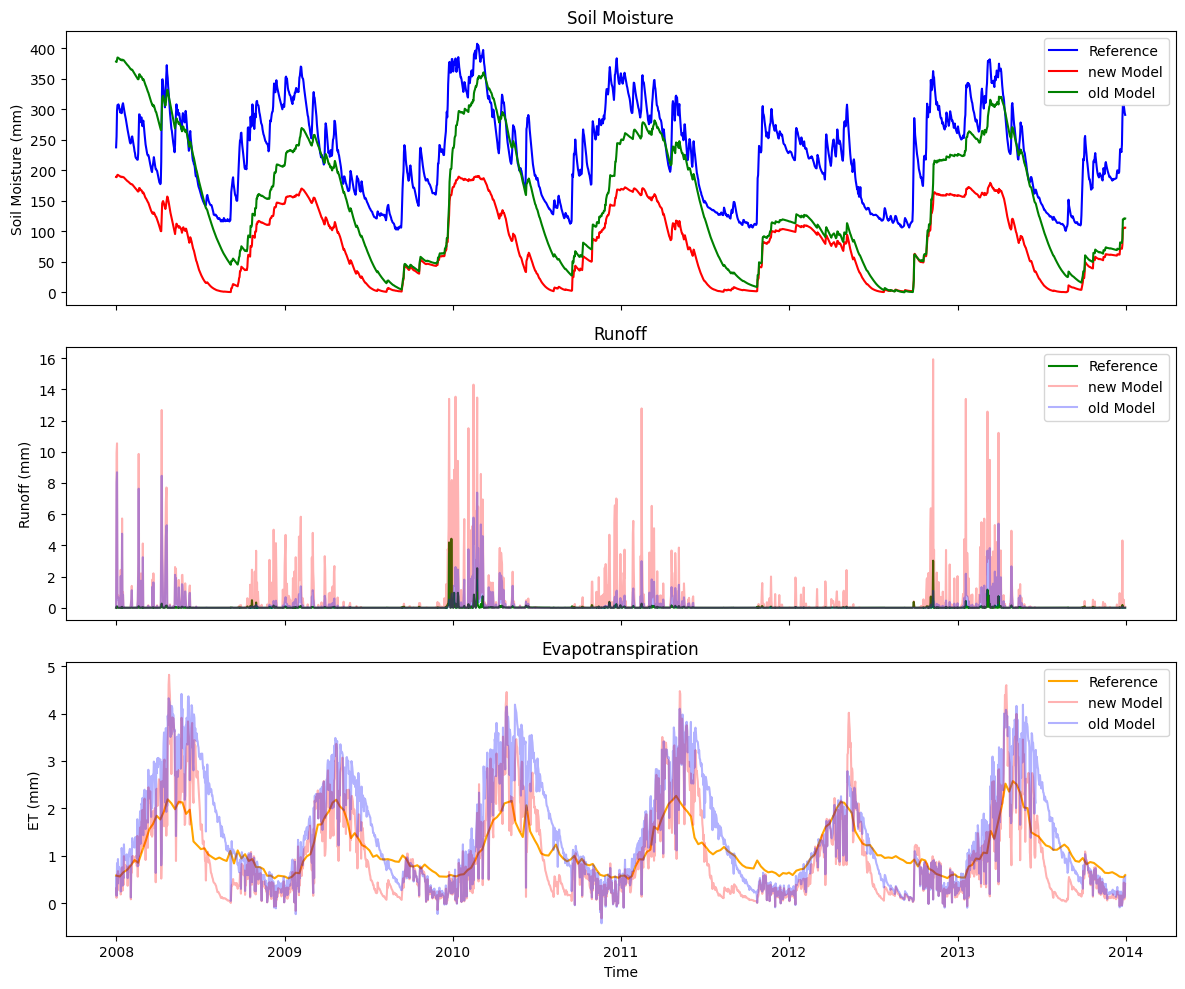

In [ ]:
# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Soil moisture
axes[0].plot(data_train_SPA['time'], data_train_SPA['sm'], color='blue', label  = 'Reference')
axes[0].set_ylabel('Soil Moisture (mm)')
axes[0].set_title('Soil Moisture')
axes[0].plot(data_train_SPA['time'], moisture2_SPA, color='red', label = 'new Model')
axes[0].plot(data_train_SPA['time'], moisture_SPA, color='green', label = 'old Model')
axes[0].legend()

# Runoff
axes[1].plot(data_train_SPA['time'], data_train_SPA['ro'], color='green', label = 'Reference')
axes[1].set_ylabel('Runoff (mm)')
axes[1].set_title('Runoff')
axes[1].plot(data_train_SPA['time'], runoff2_SPA, color='red', alpha = 0.3, label = 'new Model')
axes[1].plot(data_train_SPA['time'], runoff_SPA, color='blue', alpha = 0.3, label = 'old Model')
axes[1].legend()

# Evapotranspiration
axes[2].plot(data_train_SPA['time'], data_train_SPA['le'], color='orange', label = 'Reference')
axes[2].set_ylabel('ET (mm)')
axes[2].set_title('Evapotranspiration')
axes[2].plot(data_train_SPA['time'], et_flux2_SPA, color='red', alpha = 0.3, label = 'new Model')
axes[2].plot(data_train_SPA['time'], et_flux_SPA, color='blue', alpha = 0.3, label = 'old Model')
axes[2].set_xlabel('Time')
axes[2].legend()

plt.tight_layout()
plt.show()

## Calibrate old model

In [ ]:
# Auf alle Kombinationen anwenden
results_SPA_old = combinations_old.apply(lambda row: evaluate_combination_old(row, data_train_SPA), axis=1)

# Kombiniere Parameter und Ergebnisse
final_df_SPA_old = pd.concat([combinations_old, results_SPA_old], axis=1)

# Optional: Nach Summe der Korrelationen sortieren
final_df_SPA_old = final_df_SPA_old.sort_values('corr_sum', ascending=False)

print(final_df_SPA_old.head())

/content/drive/MyDrive/Earth_System_Modelling/Earth-System-Modelling/swbm_mini.py:33: RuntimeWarning: invalid value encountered in scalar power
  return b0 * (w_i / c_s) ** g


    c_s  a    g   b0   corr_sm   corr_ro   corr_et  corr_sum
7   210  2  0.8  0.6  0.914237  0.584170  0.852604  2.351010
8   210  2  0.8  0.8  0.920970  0.596924  0.825910  2.343804
16  210  4  0.8  0.6  0.913550  0.575073  0.853938  2.342562
15  210  4  0.8  0.4  0.903909  0.593926  0.842161  2.339996
24  210  8  0.8  0.4  0.893073  0.608689  0.836919  2.338682


In [ ]:
# Calibrated parameters
calibr_SPA_old = {
    'c_s': 210,    # soil water holding capacity in mm
    'a': 2,        # runoff function shape α
    'g': 0.8,      # ET function shape γ
    'b0': 0.6      # maximum of ET function β
}

## Run calibrations for Germany

In [ ]:
# Auf alle Kombinationen anwenden
results_GER = combinations.apply(lambda row: evaluate_combination(row, data_train_GER), axis=1)

# Kombiniere Parameter und Ergebnisse
final_df_GER = pd.concat([combinations, results_GER], axis=1)

# Optional: Nach Summe der Korrelationen sortieren
final_df_GER = final_df_GER.sort_values('corr_sum', ascending=False)

print(final_df_GER.head())

/tmp/ipython-input-496147596.py:5: RuntimeWarning: invalid value encountered in scalar power
  return b0 * (w_i / c_s) ** g * (kappa*temp**2)


     c_s  a    g   b0        k   corr_sm   corr_ro   corr_et  corr_sum  \
136  210  4  0.5  0.6  0.00045  0.908572  0.602193  0.885386  2.396151   
144  210  4  0.5  0.8  0.00035  0.908374  0.602609  0.885152  2.396135   
105  210  4  0.2  0.6  0.00040  0.906924  0.603203  0.885989  2.396117   
113  210  4  0.2  0.8  0.00030  0.906924  0.603203  0.885989  2.396117   
99   210  4  0.2  0.4  0.00060  0.906924  0.603203  0.885989  2.396117   

     corr_mean  
136   0.798717  
144   0.798712  
105   0.798706  
113   0.798706  
99    0.798706  


In [ ]:
# Define initial parameters
config = {
    'c_s': 420,    # soil water holding capacity in mm
    'a': 4,        # runoff function shape α
    'g': 0.5,      # ET function shape γ
    'b0': 0.8      # maximum of ET function β
}


In [ ]:
# Calibrated parameters
calibr_GER = {
    'c_s': 210,    # soil water holding capacity in mm
    'a': 4,        # runoff function shape α
    'g': 0.5,      # ET function shape γ
    'b0': 0.6,      # maximum of ET function β
    'kappa': 0.00045    # new parameter
}

In [ ]:
moisture_GER, runoff_GER, et_flux_GER = predict_ts(data_train_GER, config) # old SWBM old config
moisture2_GER, runoff2_GER, et_flux2_GER = predict_ts2(data_train_GER, calibr_GER) # new SWBM calibrated config

In [ ]:
# Compute correlation over the whole timeseries
corrs = model_correlation(data_train_GER, (moisture_GER, runoff_GER, et_flux_GER))
print("Correlation between observed data and model outputs:\n")
print(f"Soil Moisture (sm):      {corrs['sm']:.3f}")
print(f"Runoff (ro):             {corrs['ro']:.3f}")
print(f"Evapotranspiration (et): {corrs['et']:.3f}")
print(f"\nSum of correlations:   {corrs['sum']:.3f}")

Correlation between observed data and model outputs:

Soil Moisture (sm):      0.848
Runoff (ro):             0.604
Evapotranspiration (et): 0.882

Sum of correlations:   2.334


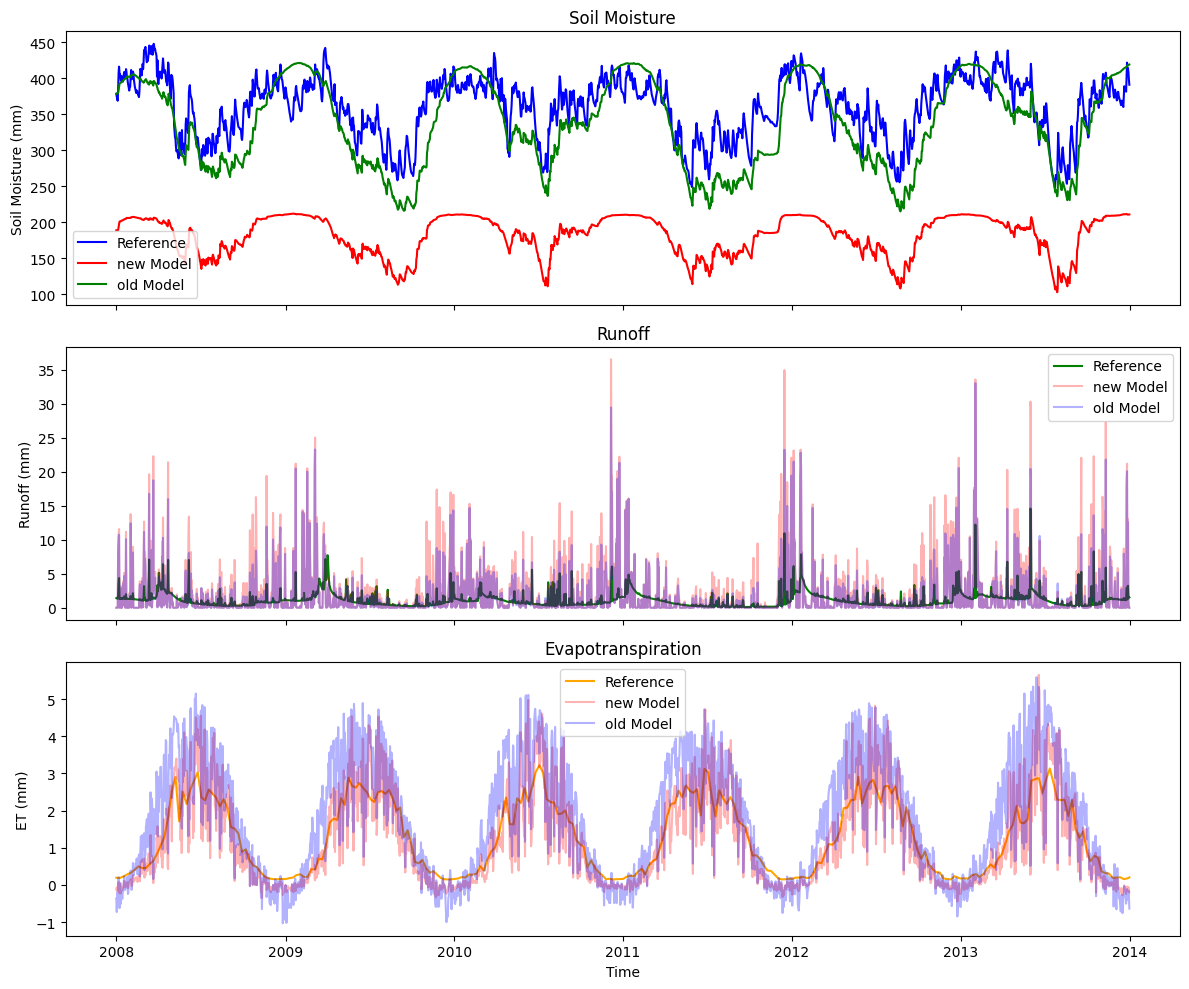

In [ ]:
# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Soil moisture
axes[0].plot(data_train_GER['time'], data_train_GER['sm'], color='blue', label  = 'Reference')
axes[0].set_ylabel('Soil Moisture (mm)')
axes[0].set_title('Soil Moisture')
axes[0].plot(data_train_GER['time'], moisture2_GER, color='red', label = 'new Model')
axes[0].plot(data_train_GER['time'], moisture_GER, color='green', label = 'old Model')
axes[0].legend()

# Runoff
axes[1].plot(data_train_GER['time'], data_train_GER['ro'], color='green', label = 'Reference')
axes[1].set_ylabel('Runoff (mm)')
axes[1].set_title('Runoff')
axes[1].plot(data_train_GER['time'], runoff2_GER, color='red', alpha = 0.3, label = 'new Model')
axes[1].plot(data_train_GER['time'], runoff_GER, color='blue', alpha = 0.3, label = 'old Model')
axes[1].legend()

# Evapotranspiration
axes[2].plot(data_train_GER['time'], data_train_GER['le'], color='orange', label = 'Reference')
axes[2].set_ylabel('ET (mm)')
axes[2].set_title('Evapotranspiration')
axes[2].plot(data_train_GER['time'], et_flux2_GER, color='red', alpha = 0.3, label = 'new Model')
axes[2].plot(data_train_GER['time'], et_flux_GER, color='blue', alpha = 0.3, label = 'old Model')
axes[2].set_xlabel('Time')
axes[2].legend()

plt.tight_layout()
plt.show()

## Calibrate old model

In [ ]:
# Auf alle Kombinationen anwenden
results_GER_old = combinations_old.apply(lambda row: evaluate_combination_old(row, data_train_GER), axis=1)

# Kombiniere Parameter und Ergebnisse
final_df_GER_old = pd.concat([combinations_old, results_GER_old], axis=1)

# Optional: Nach Summe der Korrelationen sortieren
final_df_GER_old = final_df_GER_old.sort_values('corr_sum', ascending=False)

print(final_df_GER_old.head())

    c_s  a    g   b0   corr_sm   corr_ro   corr_et  corr_sum
46  420  8  0.2  0.6  0.882638  0.595342  0.899047  2.377027
10  210  4  0.2  0.6  0.884158  0.593424  0.895452  2.373034
49  420  8  0.5  0.6  0.882573  0.594022  0.894639  2.371233
1   210  2  0.2  0.6  0.869497  0.604434  0.891094  2.365026
45  420  8  0.2  0.4  0.874829  0.588755  0.900645  2.364229


In [ ]:
# Calibrated parameters
calibr_GER_old = {
    'c_s': 420,    # soil water holding capacity in mm
    'a': 8,        # runoff function shape α
    'g': 0.2,      # ET function shape γ
    'b0': 0.6      # maximum of ET function β
}

# Run the test_data with calibrated parameter

## Sweden

In [ ]:
# Calculate Pperfromance values for calibrated new model
moisture3_SWE, runoff3_SWE, et_flux3_SWE = predict_ts2(data_test_SWE, calibr_SWE)
corrs = model_correlation(data_test_SWE, (moisture3_SWE, runoff3_SWE, et_flux3_SWE))
print("Correlation between observed data and model outputs:\n")
print(f"Soil Moisture (sm):      {corrs['sm']:.3f}")
print(f"Runoff (ro):             {corrs['ro']:.3f}")
print(f"Evapotranspiration (et): {corrs['et']:.3f}")
print(f"\nSum of correlations:   {corrs['sum']:.3f}")

Correlation between observed data and model outputs:

Soil Moisture (sm):      0.144
Runoff (ro):             0.060
Evapotranspiration (et): 0.897

Sum of correlations:   1.100


In [ ]:
# Calculate Performance for old SWBM with old initial values
moisture4_SWE, runoff4_SWE, et_flux4_SWE = predict_ts(data_test_SWE, calibr_SWE_old)
corrs = model_correlation(data_test_SWE, (moisture4_SWE, runoff4_SWE, et_flux4_SWE))
print("Correlation between observed data and model outputs:\n")
print(f"Soil Moisture (sm):      {corrs['sm']:.3f}")
print(f"Runoff (ro):             {corrs['ro']:.3f}")
print(f"Evapotranspiration (et): {corrs['et']:.3f}")
print(f"\nSum of correlations:   {corrs['sum']:.3f}")

Correlation between observed data and model outputs:

Soil Moisture (sm):      0.255
Runoff (ro):             -0.017
Evapotranspiration (et): 0.870

Sum of correlations:   1.108


In [ ]:
with pd.ExcelWriter('Outputs_Sweden.xlsx') as writer:
    pd.DataFrame(moisture3_SWE).to_excel(writer, sheet_name='New_Moisture', index=False)
    pd.DataFrame(runoff3_SWE).to_excel(writer, sheet_name='New_Runoff', index=False)
    pd.DataFrame(et_flux3_SWE).to_excel(writer, sheet_name='New_ET', index=False)
    pd.DataFrame(moisture4_SWE).to_excel(writer, sheet_name='Old_Moisture', index=False)
    pd.DataFrame(runoff4_SWE).to_excel(writer, sheet_name='Old_Runoff', index=False)
    pd.DataFrame(et_flux4_SWE).to_excel(writer, sheet_name='Old_ET', index=False)

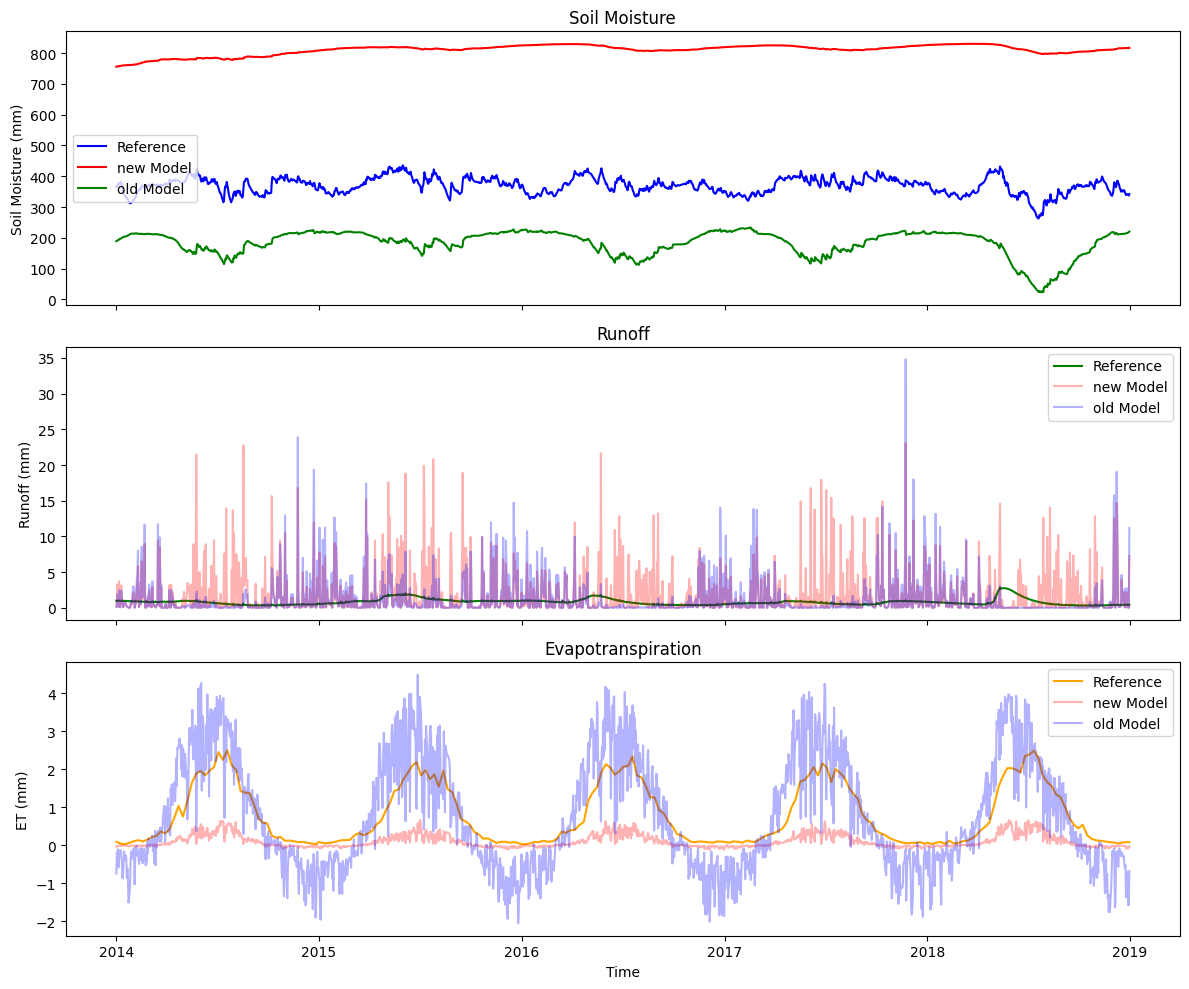

In [ ]:
# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Soil moisture
axes[0].plot(data_test_SWE['time'], data_test_SWE['sm'], color='blue', label  = 'Reference')
axes[0].set_ylabel('Soil Moisture (mm)')
axes[0].set_title('Soil Moisture')
axes[0].plot(data_test_SWE['time'], moisture3_SWE, color='red', label = 'new Model')
axes[0].plot(data_test_SWE['time'], moisture4_SWE, color='green', label = 'old Model')
axes[0].legend()

# Runoff
axes[1].plot(data_test_SWE['time'], data_test_SWE['ro'], color='green', label = 'Reference')
axes[1].set_ylabel('Runoff (mm)')
axes[1].set_title('Runoff')
axes[1].plot(data_test_SWE['time'], runoff3_SWE, color='red', alpha = 0.3, label = 'new Model')
axes[1].plot(data_test_SWE['time'], runoff4_SWE, color='blue', alpha = 0.3, label = 'old Model')
axes[1].legend()

# Evapotranspiration
axes[2].plot(data_test_SWE['time'], data_test_SWE['le'], color='orange', label = 'Reference')
axes[2].set_ylabel('ET (mm)')
axes[2].set_title('Evapotranspiration')
axes[2].plot(data_test_SWE['time'], et_flux3_SWE, color='red', alpha = 0.3, label = 'new Model')
axes[2].plot(data_test_SWE['time'], et_flux4_SWE, color='blue', alpha = 0.3, label = 'old Model')
axes[2].set_xlabel('Time')
axes[2].legend()

plt.tight_layout()
plt.show()

## Spain

In [ ]:
# Calculate Pperfromance values for calibrated new model
moisture3_SPA, runoff3_SPA, et_flux3_SPA = predict_ts2(data_test_SPA, calibr_SPA)
corrs = model_correlation(data_test_SPA, (moisture3_SPA, runoff3_SPA, et_flux3_SPA))
print("Correlation between observed data and model outputs:\n")
print(f"Soil Moisture (sm):      {corrs['sm']:.3f}")
print(f"Runoff (ro):             {corrs['ro']:.3f}")
print(f"Evapotranspiration (et): {corrs['et']:.3f}")
print(f"\nSum of correlations:   {corrs['sum']:.3f}")

Correlation between observed data and model outputs:

Soil Moisture (sm):      0.925
Runoff (ro):             0.796
Evapotranspiration (et): 0.841

Sum of correlations:   2.561


In [ ]:
# Calculate Performance for old SWBM with old initial values
moisture4_SPA, runoff4_SPA, et_flux4_SPA = predict_ts(data_test_SPA, calibr_SPA_old)
corrs = model_correlation(data_test_SPA, (moisture4_SPA, runoff4_SPA, et_flux4_SPA))
print("Correlation between observed data and model outputs:\n")
print(f"Soil Moisture (sm):      {corrs['sm']:.3f}")
print(f"Runoff (ro):             {corrs['ro']:.3f}")
print(f"Evapotranspiration (et): {corrs['et']:.3f}")
print(f"\nSum of correlations:   {corrs['sum']:.3f}")

Correlation between observed data and model outputs:

Soil Moisture (sm):      0.906
Runoff (ro):             0.819
Evapotranspiration (et): 0.876

Sum of correlations:   2.601


In [ ]:
with pd.ExcelWriter('Outputs_Spain.xlsx') as writer:
    pd.DataFrame(moisture3_SPA).to_excel(writer, sheet_name='New_Moisture', index=False)
    pd.DataFrame(runoff3_SPA).to_excel(writer, sheet_name='New_Runoff', index=False)
    pd.DataFrame(et_flux3_SPA).to_excel(writer, sheet_name='New_ET', index=False)
    pd.DataFrame(moisture4_SPA).to_excel(writer, sheet_name='Old_Moisture', index=False)
    pd.DataFrame(runoff4_SPA).to_excel(writer, sheet_name='Old_Runoff', index=False)
    pd.DataFrame(et_flux4_SPA).to_excel(writer, sheet_name='Old_ET', index=False)

## Germany

In [ ]:
# Calculate Perfromance values for calibrated new model
moisture3_GER, runoff3_GER, et_flux3_GER = predict_ts2(data_test_GER, calibr_GER)
corrs = model_correlation(data_test_GER, (moisture3_GER, runoff3_GER, et_flux3_GER))
print("Correlation between observed data and model outputs:\n")
print(f"Soil Moisture (sm):      {corrs['sm']:.3f}")
print(f"Runoff (ro):             {corrs['ro']:.3f}")
print(f"Evapotranspiration (et): {corrs['et']:.3f}")
print(f"\nSum of correlations:   {corrs['sum']:.3f}")

Correlation between observed data and model outputs:

Soil Moisture (sm):      0.914
Runoff (ro):             0.704
Evapotranspiration (et): 0.885

Sum of correlations:   2.503


In [ ]:
# Calculate Performance for old SWBM with old initial values
moisture4_GER, runoff4_GER, et_flux4_GER = predict_ts(data_test_GER, calibr_GER_old)
corrs = model_correlation(data_test_GER, (moisture4_GER, runoff4_GER, et_flux4_GER))
print("Correlation between observed data and model outputs:\n")
print(f"Soil Moisture (sm):      {corrs['sm']:.3f}")
print(f"Runoff (ro):             {corrs['ro']:.3f}")
print(f"Evapotranspiration (et): {corrs['et']:.3f}")
print(f"\nSum of correlations:   {corrs['sum']:.3f}")

Correlation between observed data and model outputs:

Soil Moisture (sm):      0.892
Runoff (ro):             0.696
Evapotranspiration (et): 0.901

Sum of correlations:   2.489


In [ ]:
with pd.ExcelWriter('Outputs_Germany.xlsx') as writer:
    pd.DataFrame(moisture3_GER).to_excel(writer, sheet_name='New_Moisture', index=False)
    pd.DataFrame(runoff3_GER).to_excel(writer, sheet_name='New_Runoff', index=False)
    pd.DataFrame(et_flux3_GER).to_excel(writer, sheet_name='New_ET', index=False)
    pd.DataFrame(moisture4_GER).to_excel(writer, sheet_name='Old_Moisture', index=False)
    pd.DataFrame(runoff4_GER).to_excel(writer, sheet_name='Old_Runoff', index=False)
    pd.DataFrame(et_flux4_GER).to_excel(writer, sheet_name='Old_ET', index=False)